<a href="https://colab.research.google.com/github/tienhuynh96/Multimodal_LLMs/blob/main/%5BDemo%5D_BLIP2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Visual Question Answering using BLIP2**



*   [Folder](https://drive.google.com/drive/folders/1TNStiLov2sXc0SbllUItQJ0K7tYyv8Ta?usp=sharing)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q peft transformers bitsandbytes datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 38.3 MB/s eta 0:00:00


In [ ]:
!pip install -q accelerate -U

In [ ]:
%cd /content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 10/Multimodal-LLM/blip2

/content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 10/Multimodal-LLM/blip2


##**Load Dataset**

In [ ]:
import os
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, dataset, processor, data_path):
        self.dataset = dataset
        self.processor = processor
        self.data_path = data_path

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # get image + text
        question = self.dataset[idx]['question']
        answer = self.dataset[idx]['answer']
        image_id = self.dataset[idx]['pid']
        image_path = os.path.join(self.data_path, f"train_fill_in_blank/train_fill_in_blank/{image_id}/image.png")
        image = Image.open(image_path).convert("RGB")
        text = question

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        labels = self.processor.tokenizer.encode(
            answer, max_length= 8, pad_to_max_length=True, return_tensors='pt'
        )
        encoding["labels"] = labels
        for k,v in encoding.items():  encoding[k] = v.squeeze()
        return encoding

##**Model**

In [ ]:
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query", "key"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 2,359,296 || all params: 387,031,868 || trainable%: 0.6095870120958619


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.cuda.empty_cache()

##**Training**

In [ ]:
from datasets import load_dataset

data_path = './IconDomainVQAData'
ds = load_dataset("json", data_files=f"{data_path}/train.jsonl")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'ques_type', 'grade', 'label', 'pid', 'unit', 'hint'],
        num_rows: 14551
    })
})

In [ ]:
ds = ds['train'].train_test_split(test_size=0.2)

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'ques_type', 'grade', 'label', 'pid', 'unit', 'hint'],
        num_rows: 8148
    })
    test: Dataset({
        features: ['question', 'answer', 'ques_type', 'grade', 'label', 'pid', 'unit', 'hint'],
        num_rows: 2037
    })
})

In [ ]:
len(ds['train']), len(ds['test'])

(8148, 2037)

In [ ]:
train_dataset = VQADataset(
    dataset=ds['test'],
    processor=processor,
    data_path=data_path
)
valid_dataset = VQADataset(
    dataset=ds['test'],
    processor=processor,
    data_path=data_path
)

In [ ]:
next(iter(train_dataset))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'pixel_values': tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         ...,
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

        [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         ...,
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

        [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
         [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
         [2.1459, 2.1459, 2.1459,  ..., 2

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
sample = next(iter(train_dataloader))

In [ ]:
sample['attention_mask'].shape

torch.Size([8, 512])

In [ ]:
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

num_epochs = 1
min_eval_loss = float("inf")
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    epoch_loss = []
    model.train()
    for idx, batch in zip(tqdm(range(len(train_dataloader)), desc=f'Training batch: {epoch+1}'), train_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                labels=labels
            )

        loss = outputs.loss
        epoch_loss.append(loss.item())

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    model.eval()
    valid_loss = []
    for idx, batch in zip(tqdm(range(len(valid_dataloader)), desc=f'Validating batch: {epoch+1}'), valid_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_masked,
                labels=labels
            )

        loss = outputs.loss
        valid_loss.append(loss.item())
    print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, sum(epoch_loss)/len(epoch_loss), sum(valid_loss)/len(valid_loss), optimizer.param_groups[0]["lr"]))
    scheduler.step()
    avg_loss = sum(valid_loss)/len(valid_loss)
    if avg_loss < min_eval_loss:
        model.save_pretrained("./save_model", from_pt=True)
        print("Saved model to ./save_model")
        min_eval_loss = valid_loss

In [ ]:
model.save_pretrained("./save_model", from_pt=True)

In [ ]:
processor.save_pretrained("./save_model", from_pt=True)

#**Inference**

In [ ]:
processor = BlipProcessor.from_pretrained("./save_model")
model = BlipForQuestionAnswering.from_pretrained("./save_model").to(device)

In [ ]:
test_data_dir = f"{data_path}/test_data/test_data"
samples = os.listdir(test_data_dir)

In [ ]:
sample_path = f"{data_path}/test_data/test_data/{samples[0]}"
sample_path

'./IconDomainVQAData/test_data/test_data/32411'

In [ ]:
# Read the json file
import json

json_path = os.path.join(sample_path, "data.json")
with open(json_path, "r") as json_file:
    data = json.load(json_file)
    question = data["question"]
    image_id = data["id"]

question, image_id

('How many diamonds are there?', '32411')

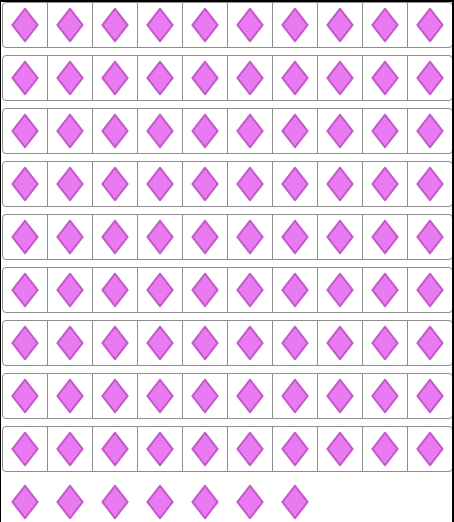

In [ ]:
# Read the corresponding image
image_path = os.path.join(test_data_dir, f"{image_id}", "image.png")
image = Image.open(image_path).convert("RGB")
image

In [ ]:
# prepare inputs
encoding = processor(image, question, return_tensors="pt").to(device, torch.float16)

out = model.generate(**encoding)
generated_text = processor.decode(out[0], skip_special_tokens=True)
generated_text

'100'